In [1]:
import requests
import affine
import datetime as dt
import pandas as pd
import geopandas as gpd
import rioxarray
import rasterio as rio
from rasterio.transform import from_origin
from rasterio.windows import Window
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from rasterio.vrt import WarpedVRT
import h5py, tabulate
import contextily as ctx
import numpy as np
import pyproj
from getpass import getpass
from IPython.display import HTML, display
from shapely.geometry import MultiPolygon, Polygon, box
from shapely.ops import orient
from pyproj import Transformer
import os
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from rasterio.transform import from_bounds


In [ ]:
# Replace these with your actual credentials
username = input('enter your username: ')
password = getpass('enter your password: ')

# Write the credentials to the .netrc file
with open('/root/.netrc', 'w') as f:
    f.write(f"machine urs.earthdata.nasa.gov login {username} password {password}\n")

# Set file permissions to secure the credentials
!chmod 0600 /root/.netrc

doi = '10.3334/ORNLDAAC/2056'# GEDI L4A DOI
doiS2 = '10.5067/HLS/HLSS30.002' # S2 DOI

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/'

doisearch = cmrurl + 'collections.json?doi=' + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()['feed']['entry'][0]['id']

print(concept_id)

In [ ]:
def search_gedi_granules(concept_id, bound, start_date, end_date, cmrurl='https://cmr.earthdata.nasa.gov/search/', data_amount = 1):
  """
  Searches for GEDI granules based on specified criteria.

  Args:
    concept_id: The concept ID of the GEDI collection.
    bound: A tuple containing the bounding box coordinates (min_lon, min_lat, max_lon, max_lat).
    start_date: The start date for the search.
    end_date: The end date for the search.
    cmrurl: The base URL for the CMR API (default: 'https://cmr.earthdata.nasa.gov/search/').

  Returns:
    A pandas DataFrame containing information about the found granules.
  """
  # Format dates and bounding box for CMR API
  dt_format = '%Y-%m-%dT%H:%M:%SZ'
  temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)
  bound_str = ','.join(map(str, bound))

  page_num = 1
  page_size = 2000  # CMR page size limit
  granule_arr = []
  
  while True:
    cmr_param = {
        "collection_concept_id": concept_id,
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "bounding_box[]": bound_str
    }

    granulesearch = cmrurl + 'granules.json'
    response = requests.get(granulesearch, params=cmr_param)
    response.raise_for_status() 
    granules = response.json()['feed']['entry']

    if granules:
      for g in granules:
          granule_url = ''
          granule_poly = ''

          # read file size
          granule_size = float(g['granule_size'])

          # reading bounding geometries
          if 'polygons' in g:
              polygons= g['polygons']
              multipolygons = []
              for poly in polygons:
                  i=iter(poly[0].split (" "))
                  ltln = list(map(" ".join,zip(i,i)))
                  multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
              granule_poly = MultiPolygon(multipolygons)

          # Get URL to HDF5 files
          for links in g['links']:
              if 'title' in links and links['title'].startswith('Download') \
              and links['title'].endswith('.h5'):
                  granule_url = links['href']
          granule_arr.append([granule_url, granule_size, granule_poly])

      page_num += 1
    else:
      break
  
  # adding bound as the last row into the dataframe
  # we will use this later in the plot
  b = list(bound)
  granule_arr.append(['bound', 0, box(b[0], b[1], b[2], b[3])])

  # creating a pandas dataframe
  l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

  # Drop granules with empty geometry
  l4adf = l4adf[l4adf['granule_poly'] != '']

  print ("Total granules found: ", len(l4adf.index)-1)
  print ("Total file size (MB): ", l4adf['granule_size'].sum())

  # drop duplicate URLs if any
  l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
  l4a_granules.to_csv('granules.txt', columns = ['granule_url'], index=False, header = False)
  
  command = f"""
  head -n {data_amount} granules.txt | tr -d '\\r' | xargs -n 1 -I {{}} bash -c 'filename=$(basename {{}}); curl -LJO -n -c ~/.urs_cookies -b ~/.urs_cookies -o "gedi_folder/$filename" {{}}; echo $filename'
  """

  result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
  downloaded_files = result.stdout.splitlines()
  return l4adf, downloaded_files
def to_csv(downloaded_files):
  hfList = []

  # read the L4A files
  for l4a in downloaded_files:
      hfList.append(h5py.File(l4a, 'r'))

  # printing root-level groups
  list(hfList[0].keys())

  # read the METADATA group
  metadata = hfList[0]['METADATA/DatasetIdentification']
  # store attributes and descriptions in an array
  data = []
  for attr in metadata.attrs.keys():
      data.append([attr, metadata.attrs[attr]])

  # display `data` array as a table
  tbl_n = 1 # table number
  print(f'Table {tbl_n}. Attributes and discription from `METADATA` group')
  headers = ["attribute", "description"]
  display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

  # read the ANCILLARY group
  ancillary = []

  for hf in hfList:
      ancillary.append(hf['ANCILLARY'])

  # read model_data subgroup
  model_data = []
  for data in ancillary:
      model_data.append(data['model_data'])

  # initialize an empty dataframe
  model_data_df = pd.DataFrame()

  first_model = model_data[0]
  # loop through parameters
  for v in first_model.dtype.names:
      # exclude multidimensional variables
      if (len(first_model[v].shape) == 1):
          # copy parameters as dataframe column
          model_data_df[v] = first_model[v]
          # converting object datatype to string
          if model_data_df[v].dtype.kind=='O':
              model_data_df[v] = model_data_df[v].str.decode('utf-8')

  # print the parameters
  tbl_n += 1
  # read pft_lut subgroup
  pft_lut = ancillary[0]['pft_lut']
  headers = pft_lut.dtype.names
  # print pft class and names
  data = zip(pft_lut[headers[0]], pft_lut[headers[1]])
  display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))
  # read region_lut subgroup
  region_lut = ancillary[0]['region_lut']
  headers = region_lut.dtype.names
  # print region class and names
  data = zip(region_lut[headers[0]], region_lut[headers[1]])
  display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))
  # index of DBT_NAm predict_stratum, idx = 6
  idx = model_data_df[model_data_df['predict_stratum']=='DBT_NAm'].index.item()
  # print vcov matrix
  model_data[0]['vcov'][idx]
  ## get predictor_id, rh_index and par for idx = 6
  predictor_id = model_data[0]['predictor_id'][idx]
  rh_index = model_data[0]['rh_index'][idx]
  par = model_data[0]['par'][idx]

  # print
  print_s = f"""predictor_id: {predictor_id}
  rh_index: {rh_index}
  par: {par}"""
  print(print_s)

  # initialize arrays
  stratum_arr, modelname_arr, fitstratum_arr, agbd_arr = [], [], [], []
  # loop the model_data_df dataframe
  for idx, row in model_data_df.iterrows():
      stratum_arr.append(model_data_df['predict_stratum'][idx])
      modelname_arr.append(model_data_df['model_name'][idx])
      fitstratum_arr.append(model_data_df['fit_stratum'][idx])
      i_0 = 0
      predictor_id = model_data[0]['predictor_id'][idx]
      rh_index = model_data[0]['rh_index'][idx]
      par = model_data[0]['par'][idx]
      model_str = 'AGBD = ' + str(par[0]) # intercept
      for i in predictor_id[predictor_id>0]:
          # use product of two RH metrics when consecutive
          # predictor_id have same values
          if (i == i_0):
              model_str += ' x RH_' + str(rh_index[i-1])
          # adding slope coefficients
          else:
              model_str += ' + ' + str(par[i]) + ' x RH_' + str(rh_index[i-1])
          i_0 = i
      # agbd model
      agbd_arr.append(model_str)

  # unique agbd models
  unique_models = list(set(agbd_arr))

  # printing agbd models by predict_stratum
  data=[]
  for model in unique_models:
      s, m, f = [], [], []
      for i, x in enumerate(agbd_arr):
          if x == model:
              s.append(stratum_arr[i])
              m.append(modelname_arr[i])
              f.append(fitstratum_arr[i])
      data.append([", ".join(s), ", ".join(list(set(m))), ", ".join(list(set(f))), model])
  tbl_n += 1
  print(f'Table {tbl_n}. AGBD Linear Models by Prediction Stratum')
  headers = ["predict_stratum", "model_name", "fit_stratum", "AGBD model"]
  display(HTML(tabulate.tabulate(data, headers, tablefmt='html', stralign="left")))

  data = []
  # loop through the root groups
  for v in list(hfList[0].keys()):
      if v.startswith('BEAM'):
          beam = hfList[0].get(v)
          b_beam = beam.get('beam')[0]
          channel = beam.get('channel')[0]
          data.append([v, hf[v].attrs['description'], b_beam, channel])

  # print as a table
  tbl_n += 1
  print(f'Table {tbl_n}. GEDI Beams')
  headers = ["beam name", "description", "beam", "channel"]
  display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

  beam_str = ['BEAM0101','BEAM0110','BEAM1000', 'BEAM1011']
  beam0110 = hf[beam_str[0]]

  data = []
  # loop over all the variables within BEAM0110 group
  for v in beam0110.keys():
      var = beam0110[v]
      source = ''
      # if the key is a subgroup assign GROUP tag
      if isinstance(var, h5py.Group):
          data.append([v, 'GROUP', 'GROUP', 'GROUP'])
      # read source, description, units attributes of each variables
      else:
          if 'source' in var.attrs.keys():
              source = var.attrs['source']
          data.append([v, var.attrs['description'], var.attrs['units'], source])

  # print all variable name and attributes as a table
  tbl_n += 1
  print(f'Table {tbl_n}. Variables within {beam_str} group')
  headers = ["variable", "description", "units", "source"]
  data = sorted(data, key=lambda x:x[3])
  display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

  # Folder to save individual CSV files
  output_folder = "hf_data"
  os.makedirs(output_folder, exist_ok=True)

  # Initialize file counter
  file_counter = 0

  for hf in hfList:
      # Temporary lists for each hf
      elev_l = []
      lat_l = []
      lon_l = []
      agbd_l = []
      error_l = []
      beam_n = []
      time_l = []
      quality_l = []

      # Loop over all base groups in each hf
      for var in list(hf.keys()):
          if var.startswith('BEAM'):
              beam = hf.get(var)
              agbd = beam.get('agbd')[:]
              error = beam.get('agbd_se')[:]
              elev = beam.get('elev_lowestmode')[:]
              lat = beam.get('lat_lowestmode')[:]
              lon = beam.get('lon_lowestmode')[:]
              time = beam.get('delta_time')[:]
              quality = beam.get('l4_quality_flag')[:]

              # Append data to temporary lists
              agbd_l.extend(agbd.tolist())
              error_l.extend(error.tolist())
              elev_l.extend(elev.tolist())
              lat_l.extend(lat.tolist())
              lon_l.extend(lon.tolist())
              time_l.extend(time.tolist())
              quality_l.extend(quality.tolist())
              n = lat.shape[0]
              beam_n.extend(np.repeat(str(var), n).tolist())

      # Create a DataFrame for the current hf
      df_hf = pd.DataFrame(list(zip(beam_n, agbd_l, error_l, elev_l, lat_l, lon_l, time_l, quality_l)),
                          columns=["beam", "agbd", "agbd_se", "elev_lowestmode", "lat_lowestmode", "lon_lowestmode", "delta_time", "l4_quality_flag"])

      # Save the DataFrame to a CSV file
      df_hf.to_csv(os.path.join(output_folder, f"hf_data_{file_counter}.csv"), index=False)

      # Clear the temporary DataFrame and lists to free RAM
      del df_hf, elev_l, lat_l, lon_l, agbd_l, error_l, beam_n, time_l, quality_l
      file_counter += 1  # Increment file counter


In [ ]:
# Example usage:
bound = (-9.0, 38.0, -8.5, 38.5)
start_date = dt.datetime(2022, 4, 1)
end_date = dt.datetime(2022, 10, 31)
data_amount = 1
l4adf, downloaded_files = search_gedi_granules(concept_id, bound, start_date, end_date, data_amount = 1)
to_csv(downloaded_files)

# 

In [14]:
from pathlib import Path
import datetime as dt
import geopandas as gpd
import pandas as pd
csv_folder = Path('./hf_data')
csv_files = list(csv_folder.glob('**/*.csv'))
def load_polygons(csv_file):
    # Read CSV file
    df = pd.read_csv(csv_file)
    
    # Convert WKT strings to geometry objects
    gdf = gpd.GeoDataFrame(
        df, 
        geometry=gpd.GeoSeries.from_wkt(df['geometry']),
        crs="EPSG:4326"  # Assuming coordinates are in WGS84
    )
    
    return gdf
def extract_index_and_date(csv_file_name):
    # name format: sample_0-2022_04_08_to_2022_04_14
    info = csv_file_name.stem.split('-')
    index = int(info[0].split('_')[1])
    date = info[1].split('_to_') # [date 1, date 2]
    # convert to datetime
    date_1 = dt.datetime.strptime(date[0], '%Y_%m_%d')
    date_2 = dt.datetime.strptime(date[1], '%Y_%m_%d')
    return index, date_1, date_2
for csv_file in csv_files:
    index, date_1, date_2 = extract_index_and_date(csv_file)
    print(index, date_1, date_2)
    break

75 2022-04-08 00:00:00 2022-04-14 00:00:00


In [23]:
polygons = load_polygons('./species.csv')
# %%
for _, polygon in polygons.iterrows():
    print(polygon.geometry.bounds)
    break

(-25.335112550572166, 37.80093047362762, -25.333545794346282, 37.80368835777847)


In [22]:
polygons.iloc[0]['geometry'].bounds

(-25.335112550572166,
 37.80093047362762,
 -25.333545794346282,
 37.80368835777847)

# to CSV

In [3]:
from src.sentinel_data.GEDI import to_csv
from pathlib import Path

gedi_folder = Path('./gedi_files')
gedi_h5 = list(gedi_folder.glob('**/*.h5'))
error_files = []
for file in gedi_h5:
    output_folder = Path('./csv_labels')
    file_name = str(file.with_suffix('.csv').name)
    
    # Check if output file already exists
    output_path = output_folder / file_name
    if output_path.exists():
        continue
    try:    
        to_csv(file,
               output_folder=output_folder,
           file_name=file_name
           )
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        error_files.append(file)
# CSV to tiff

Error processing file gedi_files/GEDI04_A_2022018011120_O17558_03_T09075_02_002_02_V002.h5: Unable to synchronously open file (truncated file: eof = 73756672, sblock->base_addr = 0, stored_eof = 320491700)


# Check the area of GEDI points

Bounds covering all polygons: (-28.731957853303246, 37.668235167444955, -6.395919342118307, 41.783758806355934)
(-8.499590926570734, 38.77199531533364, -6.395956468456142, 40.13990015731868)


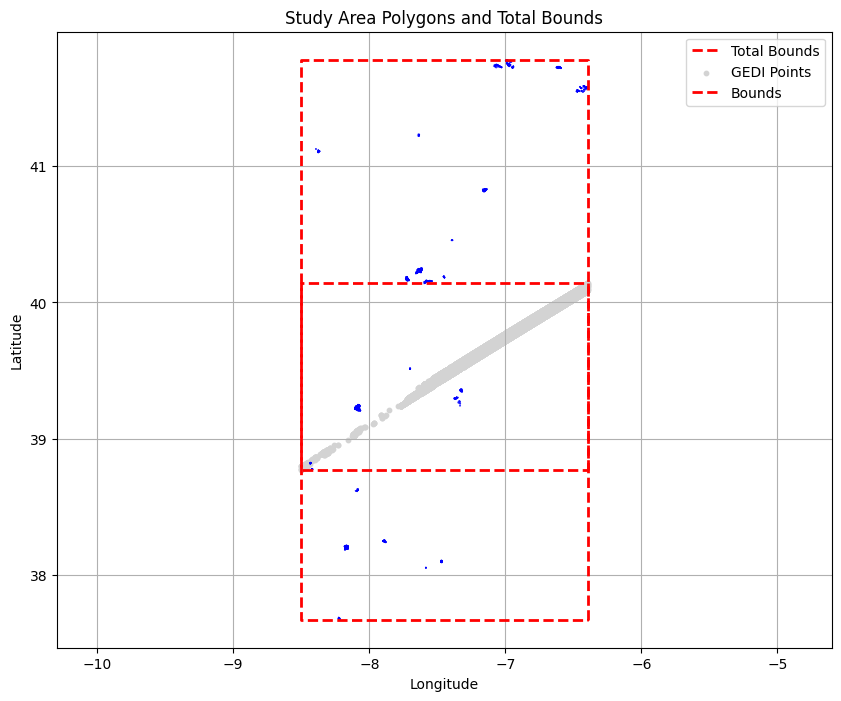

In [8]:
from data_Dwonload import load_polygons
from shapely.geometry import box
polygons = load_polygons('species.csv')
# Find the total bounds that cover all polygons
total_bounds = polygons.total_bounds  # Returns (minx, miny, maxx, maxy)
print(f"Bounds covering all polygons: {tuple(total_bounds)}")

import matplotlib.pyplot as plt

# Plot the total bounds and individual polygons
plt.figure(figsize=(10, 8))

# Plot each polygon
for idx, polygon in polygons.iterrows():
    # Only plot if longitude is >= -10
    if polygon.geometry.bounds[0] >= -8.5:
        plt.plot(*polygon.geometry.exterior.xy, 'b-', alpha=0.5, linewidth=1)

# Plot the total bounds rectangle, filtered for longitude >= -10
filtered_bounds = [
    max(-8.5, total_bounds[0]),  # minx
    total_bounds[1],            # miny 
    total_bounds[2],            # maxx
    total_bounds[3]             # maxy
]
bound_box = box(*filtered_bounds)
plt.plot(*bound_box.exterior.xy, 'r--', linewidth=2, label='Total Bounds')



import rasterio as rio
import numpy as np
import pandas as pd
# Load and plot GEDI data points from a specific file
l4adf = pd.read_csv('csv_labels/GEDI04_A_2020094133316_O07413_02_T05062_02_002_02_V002.csv')

# Create scatter plot
# plt.figure(figsize=(10, 8))

# Filter GEDI points within filtered_bounds
gedi_points = l4adf[
    (l4adf['agbd'] > 0) &
    (l4adf['lon_lowestmode'] >= filtered_bounds[0]) &
    (l4adf['lon_lowestmode'] <= filtered_bounds[2]) &
    (l4adf['lat_lowestmode'] >= filtered_bounds[1]) &
    (l4adf['lat_lowestmode'] <= filtered_bounds[3])
]

# Plot filtered GEDI points
plt.scatter(gedi_points.lon_lowestmode, gedi_points.lat_lowestmode, 
           c='lightgray', s=10,
           label='GEDI Points')

# Plot bounds of filtered points
bound = (gedi_points.lon_lowestmode.min(), 
         gedi_points.lat_lowestmode.min(),
         gedi_points.lon_lowestmode.max(), 
         gedi_points.lat_lowestmode.max())
print(bound)

bound_box = box(*bound)
plt.plot(*bound_box.exterior.xy, 'r--', linewidth=2, label='Bounds')
plt.xlabel('Longitude')
plt.ylabel('Latitude') 
plt.title('Study Area Polygons and Total Bounds')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# CSV to tiff

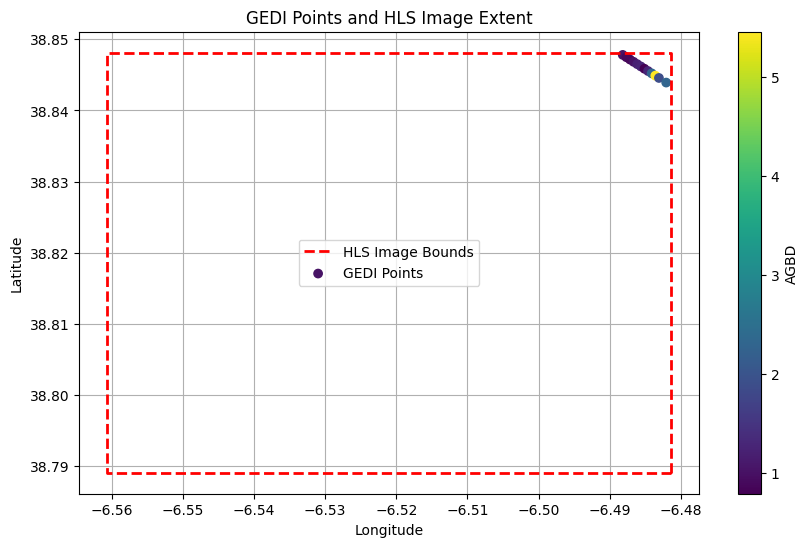

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

In [37]:
def plot_gedi_points(filtered):
    latitudes = filtered['lat_lowestmode'].values
    longitudes = filtered['lon_lowestmode'].values
    plt.figure(figsize=(10, 6))
    plt.scatter(longitudes, latitudes, color='blue', marker='x')
    plt.gca().set_facecolor('white')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('GEDI Data Point Locations')
    plt.show()
def create_gedi_raster(csv_files, hls_image, output_file="GEDI_1.tif", if_plot=False):
    """Create a raster of GEDI measurements matching the HLS image extent"""
    
    # Read HLS image properties first
    with rio.open(hls_image) as src:
        crs = src.crs
        width = src.width
        height = src.height
        transform = src.transform
        bound = src.bounds  # Get bounds from the HLS image
        
    # Read and combine CSV files
    l4adf = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

    # Filter GEDI data to HLS image extent
    filtered = l4adf[
        (l4adf['lat_lowestmode'] >= bound.bottom) & 
        (l4adf['lat_lowestmode'] <= bound.top) & 
        (l4adf['lon_lowestmode'] >= bound.left) & 
        (l4adf['lon_lowestmode'] <= bound.right) & 
        (l4adf['l4_quality_flag'] > 0) & 
        (l4adf['agbd_se']/l4adf['agbd'] * 100 > 50)
    ]

    # Create raster
    noDataValue = -1
    agbd_raster = np.full((height, width), noDataValue, dtype=np.float32)
    
    # Populate raster
    for _, row in filtered.iterrows():
        x, y = row['lon_lowestmode'], row['lat_lowestmode']
        agbd = row['agbd']
        row_idx, col_idx = ~transform * (x, y)
        row_idx, col_idx = int(row_idx), int(col_idx)
        
        if 0 <= row_idx < height and 0 <= col_idx < width:
            if agbd_raster[row_idx, col_idx] == noDataValue:
                agbd_raster[row_idx, col_idx] = agbd
            else:
                agbd_raster[row_idx, col_idx] = (agbd_raster[row_idx, col_idx] + agbd) / 2

    # Save raster
    with rio.open(
        output_file,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=agbd_raster.dtype,
        crs=crs,
        transform=transform,
        nodata=noDataValue
    ) as dst:
        dst.write(agbd_raster, 1)
        
    if if_plot and len(filtered) > 0:
        plt.figure(figsize=(10, 6))
        
        # Plot HLS image bounds
        bound_box = box(bound.left, bound.bottom, bound.right, bound.top)
        x, y = bound_box.exterior.xy
        plt.plot(x, y, 'r--', linewidth=2, label='HLS Image Bounds')
        
        # Plot GEDI points
        scatter = plt.scatter(filtered['lon_lowestmode'], filtered['lat_lowestmode'], 
                            c=filtered['agbd'], cmap='viridis', label='GEDI Points')
        plt.colorbar(scatter, label='AGBD')
        
        plt.title('GEDI Points and HLS Image Extent')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    return agbd_raster
hls_image = 'data/GEDI04_A_2021348143924_O17024_03_T06030_02_002_02_V002_patch_0.tiff'
csv_files = [hls_image.replace('_patch_0.tiff', '.csv').replace('data', 'csv_labels')]
create_gedi_raster(csv_files, hls_image, output_file="GEDI_1.tif", if_plot=True)


Image Data:
Number of bands: 9
Data type: float32
Min value: -41.0
Max value: 4989.0
Mean value: 867.4791259765625

First few pixels of first band:
[[125. 125. 141. 141. 148.]
 [208. 208. 192. 192. 202.]
 [208. 208. 192. 192. 202.]
 [289. 289. 235. 235. 220.]
 [289. 289. 235. 235. 220.]]


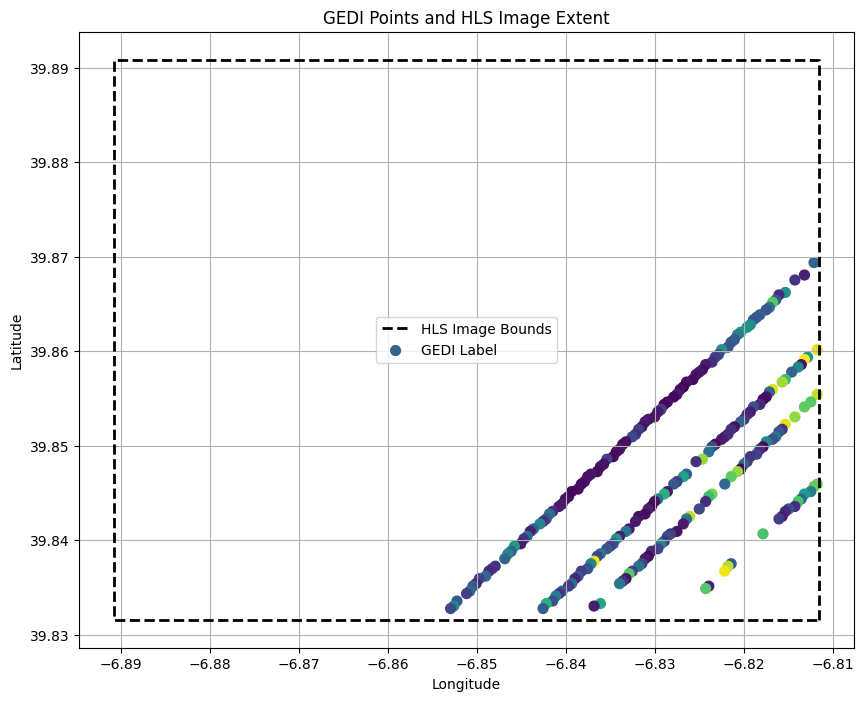

In [12]:
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio as rio
from shapely.geometry import box
import re
import numpy as np

def get_tiff_files(image_path):
    with rio.open(image_path) as src:
        data = src.read()
        bounds = src.bounds
        bound_box = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
        x, y = bound_box.exterior.xy
        return data, bound_box, x, y

plt.figure(figsize=(10, 8))
image_dir = Path('./data')
for hls_image in image_dir.glob('**/*.tiff'):
    hls_data, hls_bound_box, hls_x, hls_y = get_tiff_files(hls_image)
    plt.plot(hls_x, hls_y, 'k--', linewidth=2, label='HLS Image Bounds')
    print("\nImage Data:")
    print(f"Number of bands: {hls_data.shape[0]}")
    print(f"Data type: {hls_data.dtype}")
    print(f"Min value: {hls_data.min()}")
    print(f"Max value: {hls_data.max()}")
    print(f"Mean value: {hls_data.mean()}")
    print("\nFirst few pixels of first band:")
    print(hls_data[0, 0:5, 0:5])
    base_name = re.sub(r'_patch_\d+\.tiff$', '', str(hls_image))
    output_file = Path('./labels') / f"{hls_image.stem}_label.tiff"
    with rio.open(output_file) as src:
        label_data = src.read(1)
        transform = src.transform
        rows, cols = np.where(label_data != src.nodata)
        xs, ys = rio.transform.xy(transform, rows, cols)
    plt.scatter(xs, ys, c=label_data[rows, cols], cmap='viridis', s=50, marker='o', label='GEDI Label')
    break
# Read and plot both rasters



# Plot GEDI points
# with rio.open(output_file) as src:
#     gedi_data = src.read(1)
#     transform = src.transform
#     height, width = gedi_data.shape
#     print(f"GEDI raster size: {height} x {width}")
    
#     # Create coordinates for each pixel
#     rows, cols = np.where(gedi_data != src.nodata)
#     xs, ys = rio.transform.xy(transform, rows, cols)
    
#     # Plot valid GEDI points
#     scatter = plt.scatter(xs, ys, c=gedi_data[rows, cols], 
#                          cmap='viridis', s=50, marker='o', 
#                          label='GEDI Points')
#     plt.colorbar(scatter, label='AGBD')

plt.title('GEDI Points and HLS Image Extent')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
# Get list of all tiff files in data directory
data_folder = Path('./data')
tiff_files = list(data_folder.glob('**/*.tiff'))

# Store mean values for each file
mean_values = []

# Process each tiff file
for tiff_file in tiff_files:
    if 'GEDI04_A_2021200184655_O14733_02_T09331_02_002_02_V002_patch_15.tiff' in tiff_file.name:
        with rio.open(tiff_file) as src:
            data = src.read()
            # Calculate mean, ignoring nodata values (-1)
            mean = np.mean(data[data != -1])
            mean_values.append(mean)
            print(f"{tiff_file.name}: Mean value = {mean:.2f}")

# Calculate overall mean if there are any values
if mean_values:
    overall_mean = np.mean(mean_values)
    print(f"\nOverall mean across all files: {overall_mean:.2f}")
else:
    print("\nNo tiff files found in data directory")


GEDI04_A_2021200184655_O14733_02_T09331_02_002_02_V002_patch_15.tiff: Mean value = 1437.16

Overall mean across all files: 1437.16


In [57]:
from pathlib import Path
len(list(Path('./data').glob('**/*.tiff')))


1483

# Check the area and GEDI points

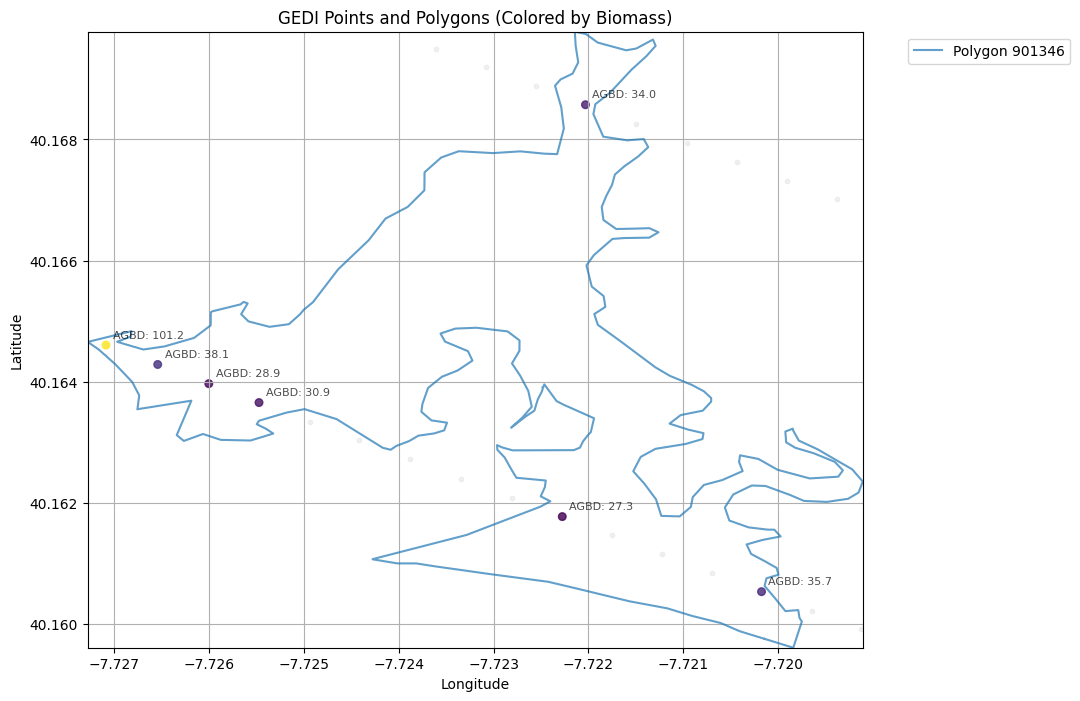

In [39]:

def load_polygons(csv_file):
    """
    Load polygon data from CSV file containing WKT geometry strings.
    
    Args:
        csv_file (str): Path to CSV file containing polygon data
        
    Returns:
        gpd.GeoDataFrame: GeoDataFrame containing the polygon data
    """
    # Read CSV file
    df = pd.read_csv(csv_file)
    
    # Convert WKT strings to geometry objects
    gdf = gpd.GeoDataFrame(
        df, 
        geometry=gpd.GeoSeries.from_wkt(df['geometry']),
        crs="EPSG:4326"  # Assuming coordinates are in WGS84
    )
    
    return gdf
def extract_gedi_datetime(filename):
    # Extract just the filename if full path is given
    filename = os.path.basename(filename)
    
    # Split filename into components
    parts = filename.split('_')
    
    # Extract time string (format: YYYYDDDHHMMSS)
    time_str = parts[2]  # e.g., '2022100110841'
    
    # Parse components
    year = int(time_str[:4])           # First 4 digits: year
    doy = int(time_str[4:7])           # Next 3 digits: day of year
    hour = int(time_str[7:9])          # Next 2 digits: hour
    minute = int(time_str[9:11])       # Next 2 digits: minute
    second = int(time_str[11:])        # Last 2 digits: second
    
    # Convert to datetime
    date = datetime(year, 1, 1) + timedelta(days=doy-1)
    final_datetime = date.replace(hour=hour, minute=minute, second=second)
    
    # Extract additional metadata
    metadata = {
        'orbit_number': parts[3][1:],    # Remove 'O' prefix
        'track_number': parts[5][1:],    # Remove 'T' prefix
        'version': parts[-1].replace('.h5', '')  # Remove .h5 extension
    }
    
    return final_datetime, metadata
info = pd.read_csv('polygon_info.csv')
def plot_gedi_points_in_poly(info, i):
    geo = gpd.GeoDataFrame(
        info,
        geometry=gpd.GeoSeries.from_wkt(info['polygon_geometry']),
        crs="EPSG:4326"
    )
    csv_file = geo.iloc[i].csv_file
    geometry = geo.iloc[i].geometry
    idx = geo.iloc[i].polygon_index


    l4adf = pd.read_csv(Path('./hf_data')/csv_file)
    gedi_points = gpd.GeoDataFrame(
        l4adf,
        geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode),
        crs="EPSG:4326"
    )
    plt.figure(figsize=(10,8))
    plt.scatter(gedi_points.lon_lowestmode, gedi_points.lat_lowestmode, c='lightgray', s=10, alpha=0.3)

    # Get bounds of geometry to zoom in
    bounds = geometry.bounds

    # Find points within polygon and plot them colored by biomass
    points_in_poly = gedi_points[gedi_points.geometry.within(geometry)]
    if not points_in_poly.empty:
        scatter = plt.scatter(points_in_poly.lon_lowestmode, points_in_poly.lat_lowestmode, 
                            c=points_in_poly.agbd, cmap='viridis', s=30, alpha=0.8)
        
        # Add annotations for each point
        for idx, point in points_in_poly.iterrows():
            plt.annotate(f'AGBD: {point.agbd:.1f}',
                        (point.lon_lowestmode, point.lat_lowestmode),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.7)

    plt.plot(geometry.exterior.xy[0], geometry.exterior.xy[1], alpha=0.7, label=f'Polygon {idx}')
    plt.xlim(bounds[0], bounds[2])  # Set x limits to polygon bounds
    plt.ylim(bounds[1], bounds[3])  # Set y limits to polygon bounds
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('GEDI Points and Polygons (Colored by Biomass)')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()  

plot_gedi_points_in_poly(info, 55)



Checking Polygon 0...
No GEDI points found for Polygon 0

Checking Polygon 1...
No GEDI points found for Polygon 1

Checking Polygon 2...
No GEDI points found for Polygon 2

Checking Polygon 3...
No GEDI points found for Polygon 3

Checking Polygon 4...
No GEDI points found for Polygon 4

Checking Polygon 5...
No GEDI points found for Polygon 5

Checking Polygon 6...
No GEDI points found for Polygon 6

Checking Polygon 7...
No GEDI points found for Polygon 7

Checking Polygon 8...
No GEDI points found for Polygon 8

Checking Polygon 9...
No GEDI points found for Polygon 9

Checking Polygon 10...
No GEDI points found for Polygon 10

Checking Polygon 11...
No GEDI points found for Polygon 11

Checking Polygon 12...
No GEDI points found for Polygon 12

Checking Polygon 13...
No GEDI points found for Polygon 13

Checking Polygon 14...
No GEDI points found for Polygon 14

Checking Polygon 15...
No GEDI points found for Polygon 15

Checking Polygon 16...
No GEDI points found for Polygon 16


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x72e8353ffa90>>
Traceback (most recent call last):
  File "/home/glyin/anaconda3/envs/granite_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


No GEDI points found for Polygon 42

Checking Polygon 43...
No GEDI points found for Polygon 43

Checking Polygon 44...
No GEDI points found for Polygon 44

Checking Polygon 45...
No GEDI points found for Polygon 45

Checking Polygon 46...
No GEDI points found for Polygon 46

Checking Polygon 47...
No GEDI points found for Polygon 47

Checking Polygon 48...
No GEDI points found for Polygon 48

Checking Polygon 49...
No GEDI points found for Polygon 49

Checking Polygon 50...
No GEDI points found for Polygon 50

Checking Polygon 51...
No GEDI points found for Polygon 51

Checking Polygon 52...
No GEDI points found for Polygon 52

Checking Polygon 53...
No GEDI points found for Polygon 53

Checking Polygon 54...
No GEDI points found for Polygon 54

Checking Polygon 55...
No GEDI points found for Polygon 55

Checking Polygon 56...
No GEDI points found for Polygon 56

Checking Polygon 57...
